In [1]:
import numpy as np
import matplotlib
from matplotlib import rc
import matplotlib.pyplot as plt
import matplotlib.patches
import time
from matplotlib.ticker import MaxNLocator
import os, sys
from astropy.io import fits
from astropy.stats import sigma_clip
from photutils import aperture_photometry
from photutils import CircularAperture
from numpy import std
import glob
import csv
import operator
import matplotlib.ticker as mtick
from photutils.datasets import make_4gaussians_image
#from photutils.morphology import (centroid_com,centroid_1dg,centroid_2dg)
from time import time
#from scipy.linalg.fblas import dgemm
from astropy.convolution import convolve, Box1DKernel
import collections
from astropy.convolution import Gaussian1DKernel

import os, sys

In [2]:
%matplotlib inline

In [3]:
def get_full_data(foldername):
    path = foldername + '/ch2_datacube_full_AORs579.dat'
    flux     = np.loadtxt(path, usecols=[0], skiprows=1)     # Flux from circular aperture (MJy/str)
    time     = np.loadtxt(path, usecols=[2], skiprows=1)     # time in days?
    xdata    = np.loadtxt(path, usecols=[3], skiprows=1)     # x-centroid (15 = center of 15th pixel)
    ydata    = np.loadtxt(path, usecols=[4], skiprows=1)     # y-centroid (15 = center of 15th pixel)
    psfwx    = np.loadtxt(path, usecols=[5], skiprows=1)     # psf width in pixel size (FWHM of 2D Gaussian)
    psfwy    = np.loadtxt(path, usecols=[6], skiprows=1)     # psf width in pixel size (FWHM of 2D Gaussian)    
    return flux, time, xdata, ydata, psfwx, psfwy

In [4]:
def get_data(folderdata):
    path = folderdata + '/ch2_datacube_binned_AORs579.dat'
    path2= folderdata + '/popt.dat'
    
    #Loading Data (Aperture)
    flux     = np.loadtxt(path, usecols=[0], skiprows=1)     # Flux from circular aperture (MJy/str)
    flux_err = np.loadtxt(path, usecols=[1], skiprows=1)     # Flux uncertainty from circular aperture (MJy/str)
    time     = np.loadtxt(path, usecols=[2], skiprows=1)     # Time in days
    xdata    = np.loadtxt(path, usecols=[4], skiprows=1)     # x-centroid (15 = center of 15th pixel)
    ydata    = np.loadtxt(path, usecols=[6], skiprows=1)     # y-centroid (15 = center of 15th pixel)
    psfwx    = np.loadtxt(path, usecols=[8], skiprows=1)     # psf width in pixel size (FWHM of 2D Gaussian)
    psfwy    = np.loadtxt(path, usecols=[10], skiprows=1)    # psf width in pixel size (FWHM of 2D Gaussian)
    
    return flux, flux_err, time, xdata, ydata, psfwx, psfwy 

In [5]:
'''Get list of directories'''
def get_fnames(directory):
    '''
    Find paths to all the fits files.

    Parameters
    ----------

    directory : string object
        Path to the directory containing all the Spitzer data.

    AOR_snip  : string object
        Common first characters of data directory eg. 'r579'

    ch        : string objects
        Channel used for the observation eg. 'ch1' for channel 1    

    Returns
    -------

    fname     : list
        List of paths to all bcd.fits files.

    len(fnames): int
        Number of fits file found.
    '''
    lst      = os.listdir(directory)
    Run_list = [k for k in lst if 'Run' in k]
    return Run_list, len(Run_list)

In [7]:
'''HARD CODED'''

direc = 'C:/Users/Lisa/Documents/Exoplanets/High_Precision_Photometry'
Run_list = get_fnames(direc)

Run_list1 = ['Run1', 'Run2','Run3', 'Run4', 'Run5', 'Run6', 'Run7', 'Run8']
Run_list2 = ['Run15', 'Run16', 'Run17', 'Run18', 'Run19', 'Run20', 'Run21', 'Run22', 'Run23']
Run_list3 = ['Run25', 'Run26', 'Run27', 'Run28', 'Run29', 'Run30', 'Run31', 'Run32', 'Run33']
Run_list4 = ['Run35', 'Run36', 'Run37', 'Run38', 'Run39', 'Run40', 'Run41', 'Run42', 'Run43']
Run_list5 = ['Run45', 'Run46', 'Run47', 'Run48', 'Run49', 'Run50', 'Run51', 'Run52', 'Run53']
Run_list6 = ['Run55', 'Run56', 'Run57', 'Run58', 'Run59', 'Run60', 'Run61', 'Run62', 'Run63']

In [8]:
def highpassflist(signal):

    '''
    # Binning version
    binstak=map(binning_data,flist1)
    binstak=np.asarray(binstak)
    print 'lengths',len(binstak),len(binstak[0])
    flist1=binstak
    '''
    #g = Gaussian1DKernel(stddev=10)
    g = Box1DKernel(10)
    smooth=convolve(np.asarray(signal), g,boundary='extend')
    ''' flist1=np.asarray(flist1)
    flist2=np.asarray(flist2)
    
    smooth=flist1-flist2'''
    
    '''
    sflist = map(normstar,smooth)
    sflist = map( lambda t: t-1, sflist)
    panel=map(lambda t: np.sqrt(np.nanmean(np.square(t))), sflist)
    '''
    return smooth


In [9]:
def RMS(x):
    n=len(x)
    x2 = np.multiply(x,x)
    sumx2 =np.sum(x2)
    x_RMS = np.sqrt((1.0/n)*sumx2)
    return x_RMS

In [10]:
def get_RMS(Run_list):
    RMS_list = np.empty(len(Run_list))
    for i in range(len(Run_list)):
        foldername = Run_list[i]
        flux, flux_err, time, xdata, ydata, psfwx, psfwy = get_data(foldername)
        smooth = highpassflist(flux)
        residual = flux - smooth 
        RMS_list[i] = RMS(residual)
        path = Run_list[i] + '/RMS_Scatter.pdf'
        fig, axes = plt.subplots(ncols = 1, nrows = 2, sharex = True, figsize = (10,6))
        fig.suptitle('RMS = '+ str(RMS_list[i]))
        axes[0].plot(time, flux, 'k.', alpha = 0.15, label='Measured Flux')
        axes[0].plot(time, smooth, '+', label = 'Filtered')
        axes[0].set_ylabel('Relative Flux')
        axes[1].plot(time, flux-smooth, 'k.', alpha =0.1)
        axes[1].set_xlim(np.min(time), np.max(time))
        axes[1].axhline(y=0, color='b', linewidth = 1)
        axes[1].set_ylabel('Residual')
        axes[1].set_xlabel('Time since IRAC turn on(days)')
        fig.subplots_adjust(hspace=0)
        fig.savefig(path)
    return RMS_list

In [22]:
'''Special PSF Fit'''

def binning_data(data, size):
    data = np.ma.masked_invalid(data) 
    reshaped_data   = data.reshape((len(data)/size, size))
    binned_data     = np.ma.median(reshaped_data, axis=1)
    binned_data_std = np.std(reshaped_data, axis=1)
    return binned_data, binned_data_std


folderdata = 'Run44'
path2= folderdata + '/popt.dat'

    #Loading data from PSF fit
popt     = np.loadtxt(path2, skiprows=1)
    
flux2, flux2_err   = binning_data(popt[0,:],64)
xdata2, xdata2_err = binning_data(popt[2,:],64)
ydata2, ydata2_err = binning_data(popt[1,:],64)
psfwx2, psfwx2_err = binning_data(popt[4,:],64)
psfwy2, psfwy2_err = binning_data(popt[3,:],64)

flux2    = flux2*0.029691810510039204
#factor2  = 1/(np.median(flux2))
#flux2    = factor2*flux2
#flux2_err= factor2*flux2_err

flux, flux_err, time, xdata, ydata, psfwx, psfwy = get_data(folderdata)

C:\Users\Lisa\Anaconda3\lib\site-packages\numpy\ma\core.py:4474: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  result = self._data.reshape(*s, **kwargs).view(type(self))
C:\Users\Lisa\Anaconda3\lib\site-packages\numpy\ma\core.py:4478: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  result._mask = mask.reshape(*s, **kwargs)


1358
1.85135720475


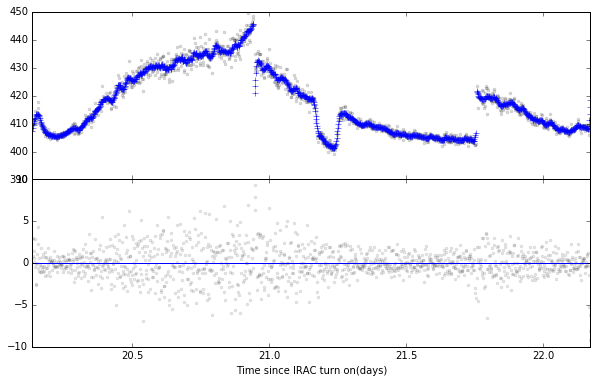

In [23]:
smooth = highpassflist(flux2)
residual = flux2-smooth
print(len(flux2))
print(RMS(residual))

fig, axes = plt.subplots(ncols = 1, nrows = 2, sharex = True, figsize = (10,6))
axes[0].plot(time, flux2, 'k.', alpha = 0.15)
axes[0].plot(time, smooth, '+')
axes[1].plot(time, flux2-smooth, 'k.', alpha =0.1)
axes[1].set_xlim(np.min(time), np.max(time))
axes[1].axhline(y=0, color='b', linewidth = 1)
axes[1].set_xlabel('Time since IRAC turn on(days)')
fig.subplots_adjust(hspace=0)

C:\Users\Lisa\Anaconda3\lib\site-packages\matplotlib\pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


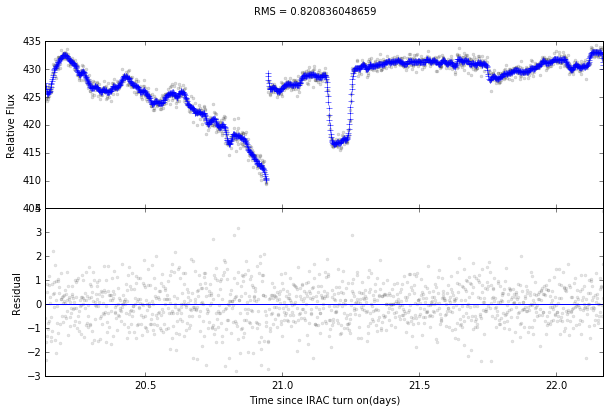

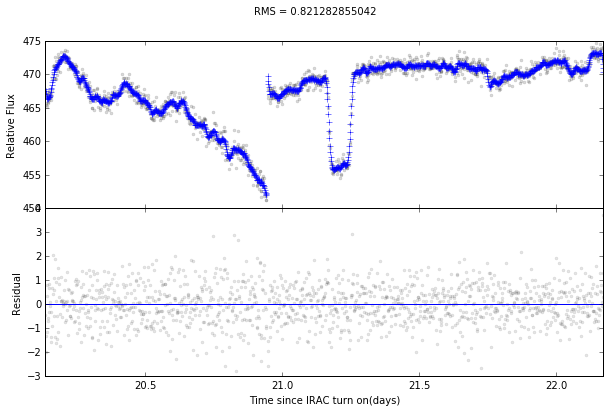

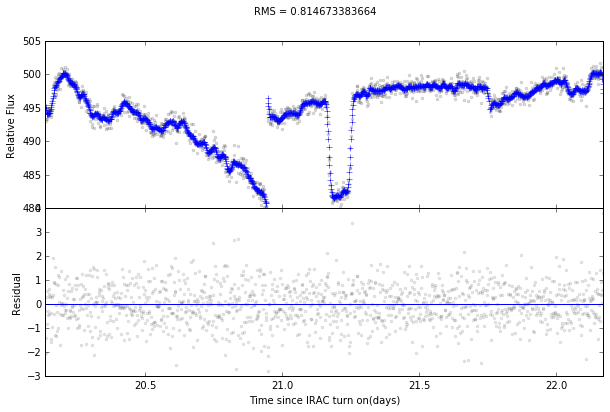

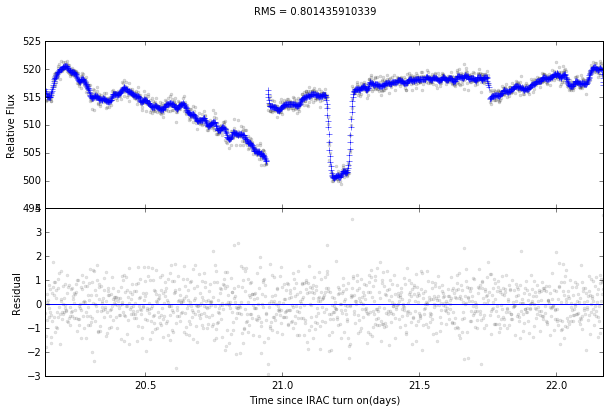

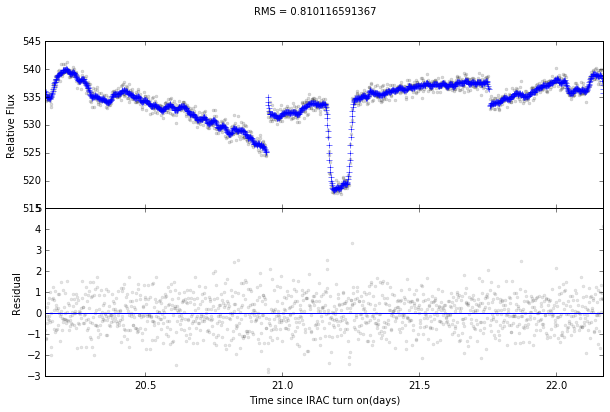

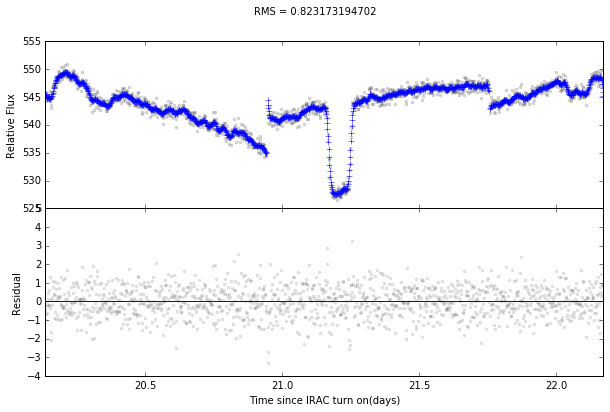

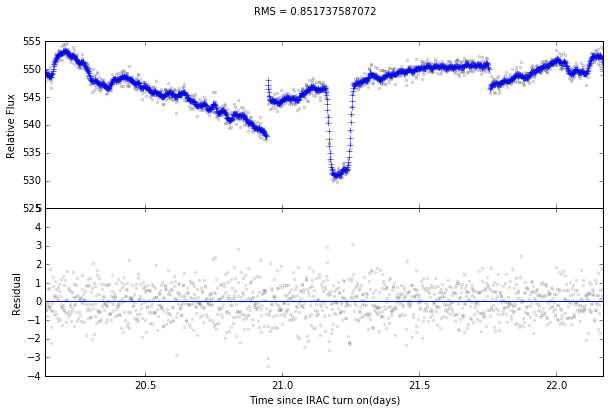

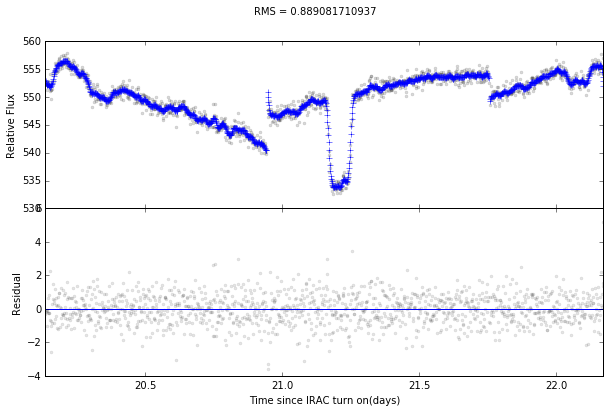

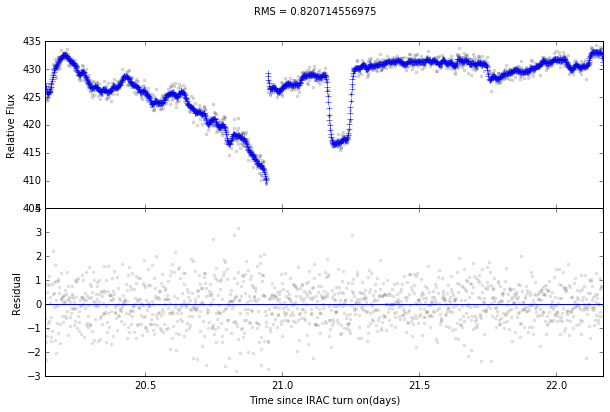

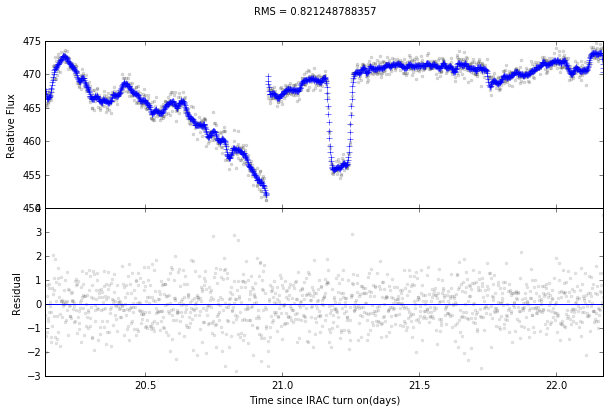

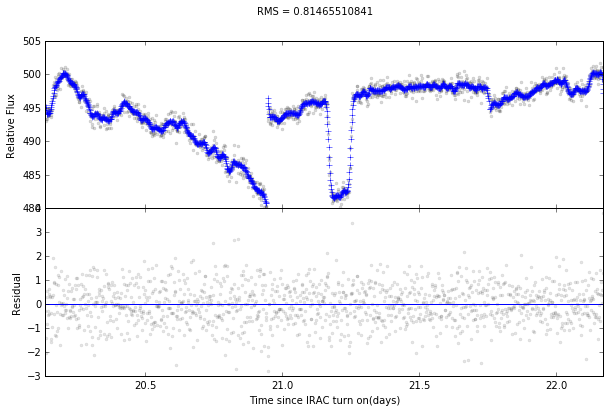

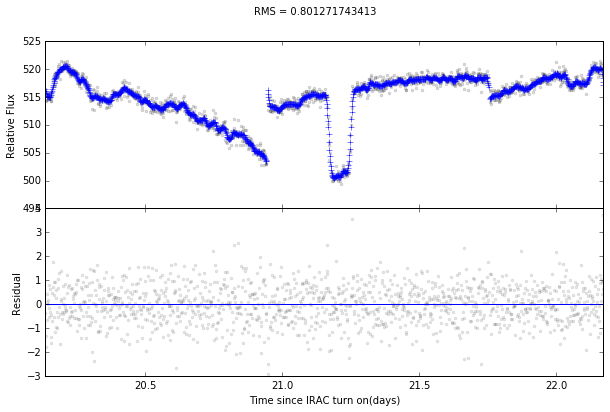

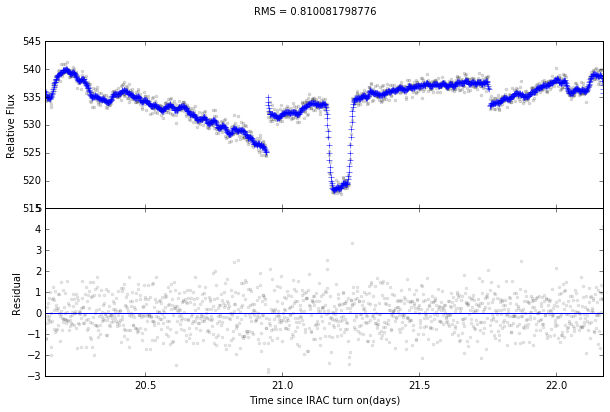

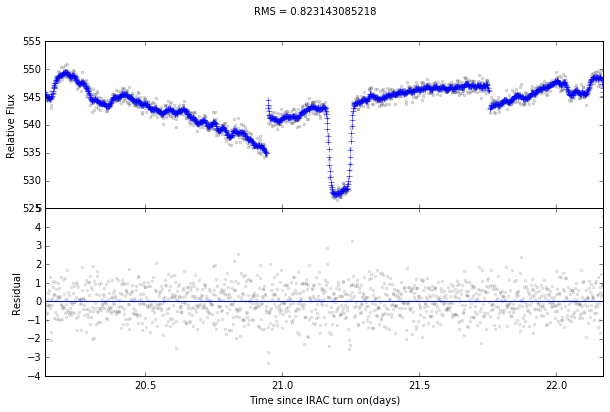

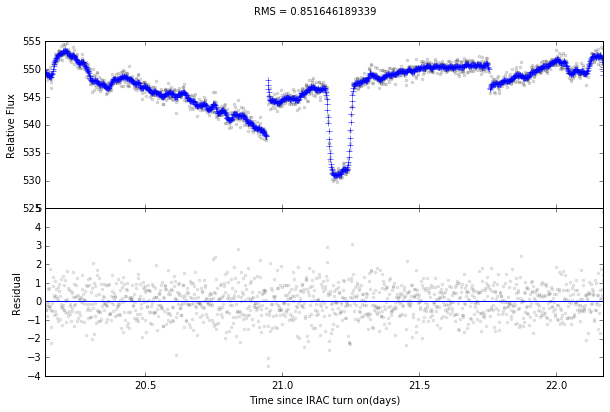

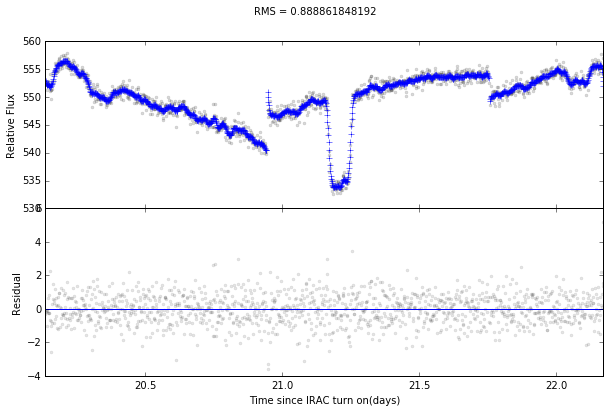

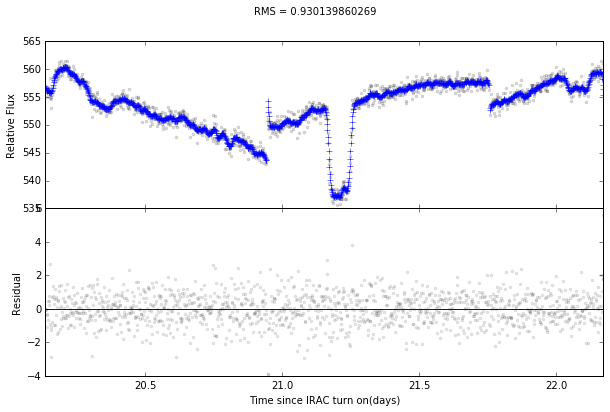

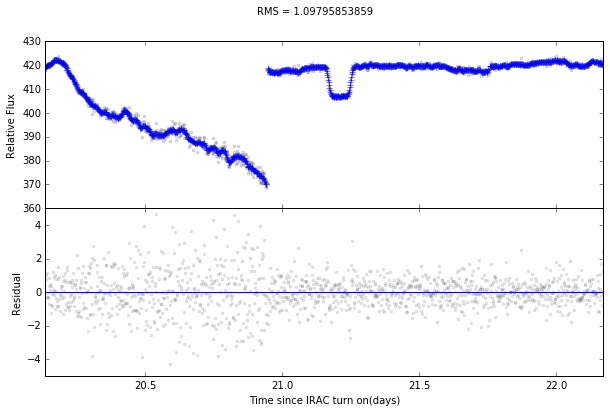

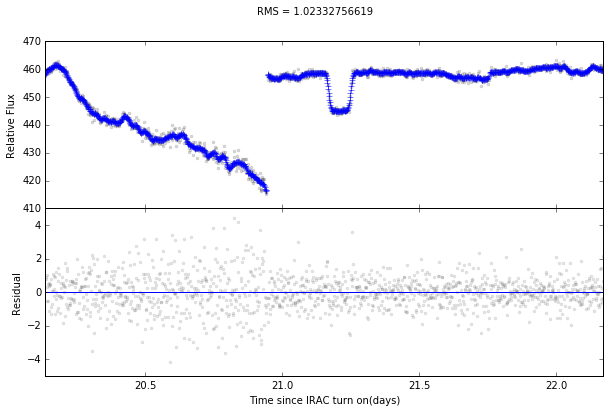

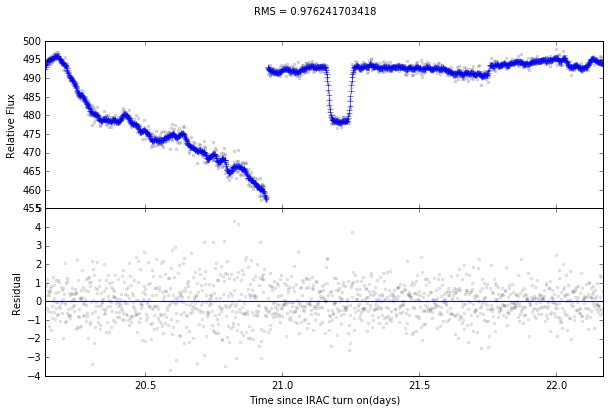

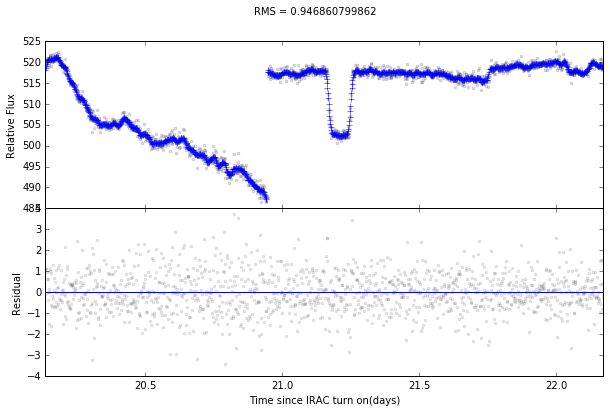

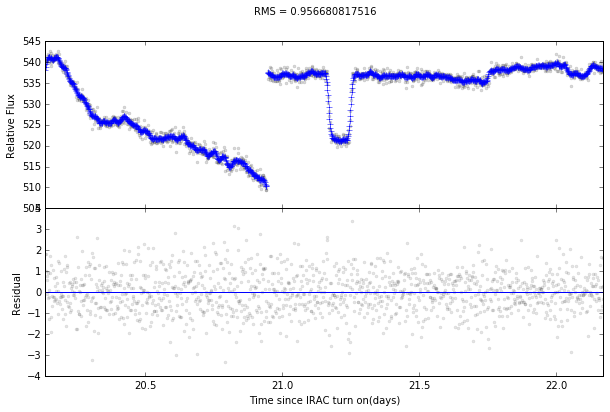

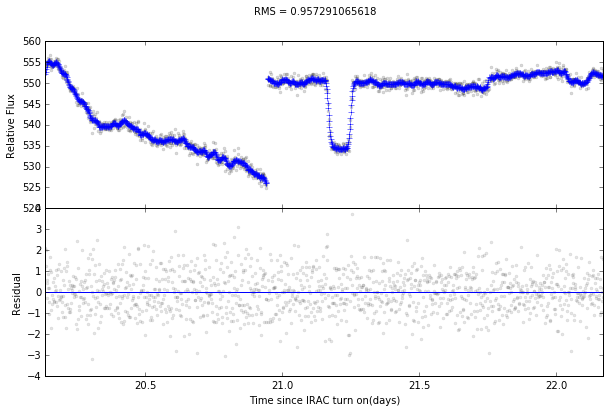

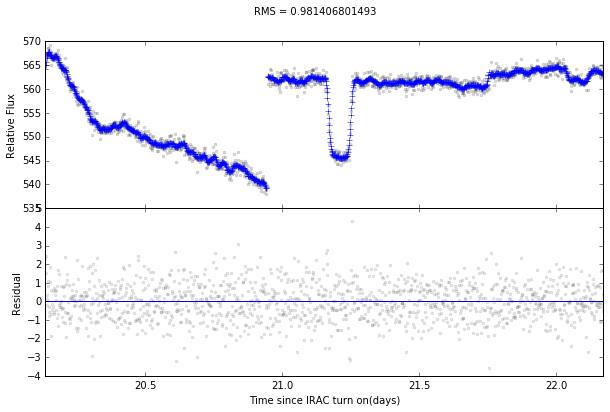

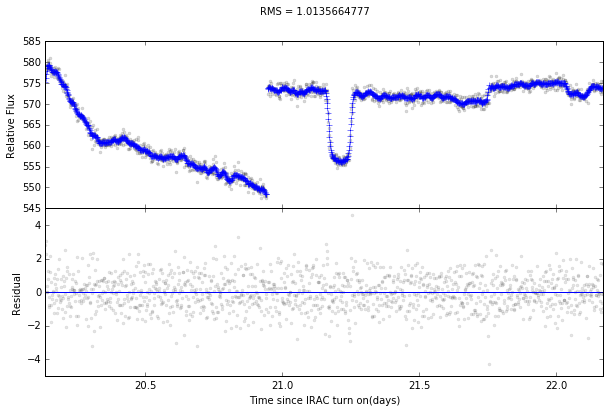

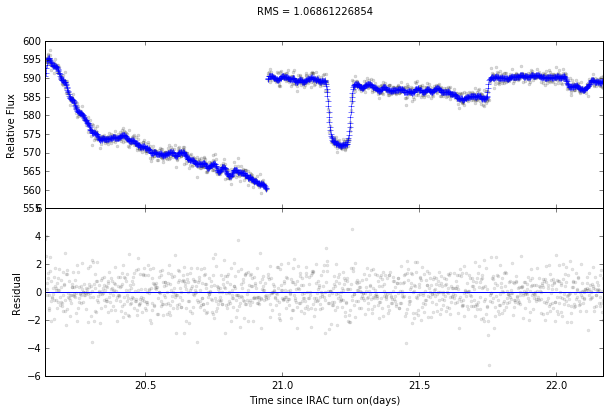

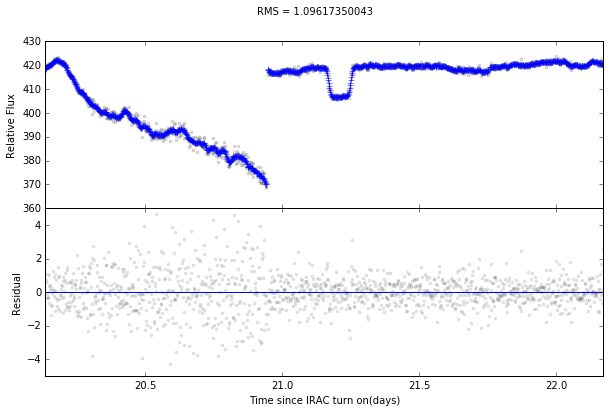

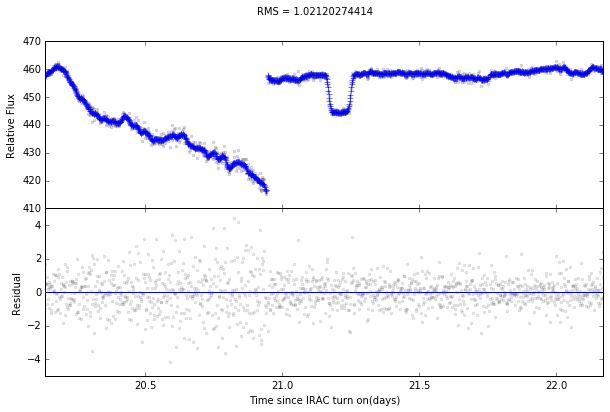

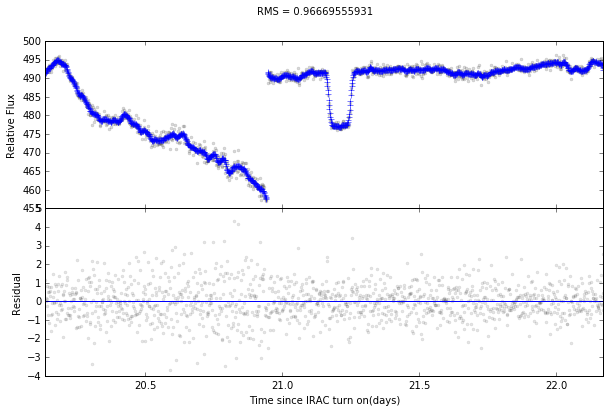

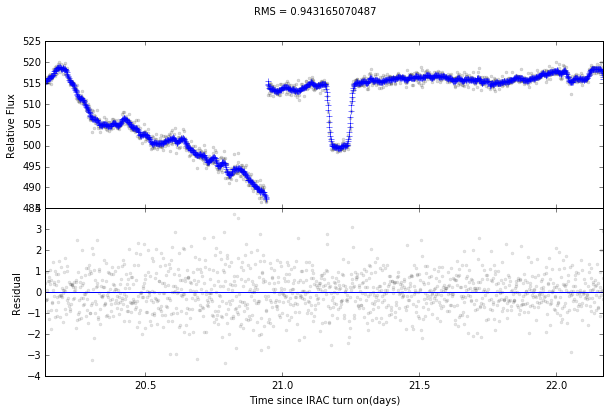

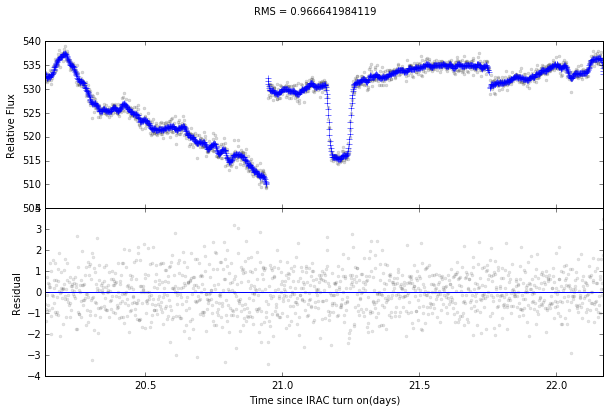

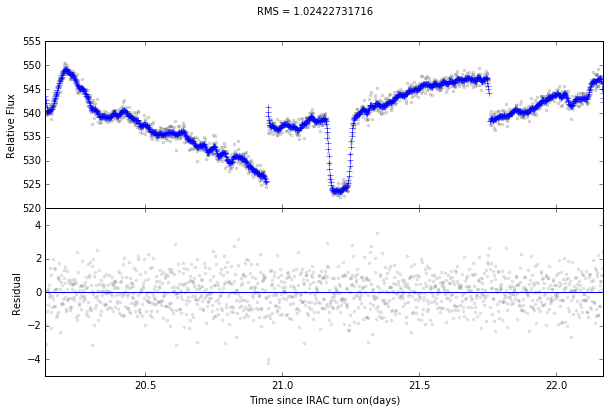

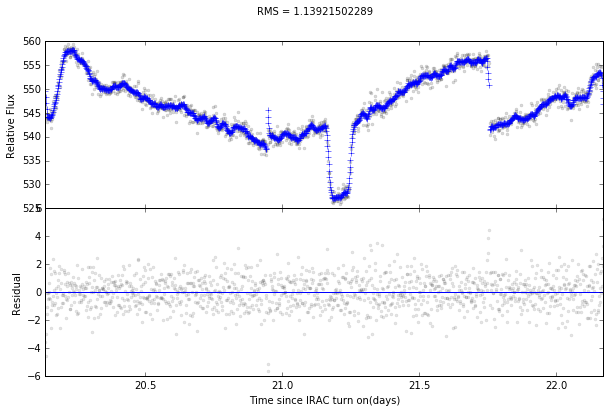

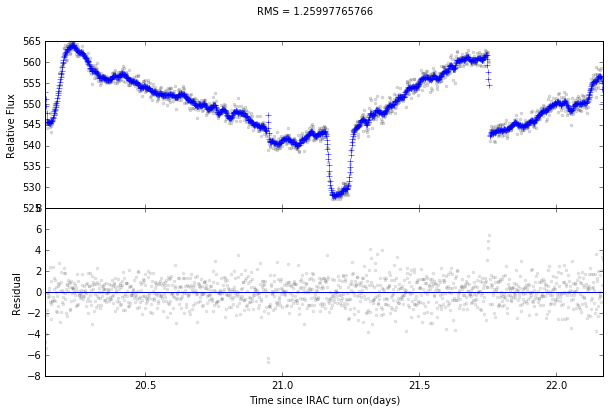

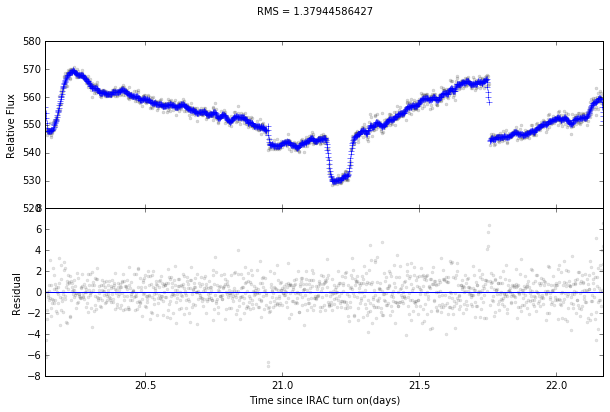

In [11]:
RMS1 = get_RMS(Run_list1)
#RMS2 = get_RMS(Run_list2)
RMS3 = get_RMS(Run_list3)
#RMS4 = get_RMS(Run_list4)
RMS5 = get_RMS(Run_list5)
RMS6 = get_RMS(Run_list6)

In [12]:
Radius = [1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25]
Radius2 = [1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5]

In [1]:
plt.figure(figsize = (10,4))
plt.plot(Radius,  RMS1, 'x-', label = 'Soft Edge + Companion Subtracted')
#plt.plot(Radius2, RMS2, 'x-', label = 'Oversampled + Hard Edge')
plt.plot(Radius2, RMS5, 'x-', label = 'Oversampled + Hard Edge')
plt.plot(Radius2, RMS3, 'x--', label = 'Hard Edge + Companion Subtracted')
plt.plot(Radius2, RMS6, 'x-', label = 'Oversampled + Companion Sub+ Hard Edge')
#plt.plot(Radius2, RMS4, 'x--', label = 'new')
plt.axhline(y=1.39485316958, color='orange', linewidth = 1, label = 'PSF Fitting')
#plt.axhline(y=RMS45, color='orange', linewidth = 1)
plt.xlabel('Aperture Radius')
plt.ylabel('RMS Scatter')
plt.ylim(0.76,2)
plt.legend(loc=2)

#plt.yscale("log", nonposx='clip')
figpath = 'Plots/Photometry_Comparison.pdf'
#plt.savefig(figpath)

NameError: name 'plt' is not defined